In [1]:
import random, os, tqdm, time, json
import numpy as np
import pandas as pd
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

import sys
sys.path.append("../../../")

random.seed(618)
np.random.seed(907)

new_base_path = os.path.join(
    "/Users/minkexiu/Downloads/",
    "/".join(
        os.getcwd().split("/")[-1*(len(sys.path[-1].split("/")) - 1):]
    ),
)
print("storage dir:", new_base_path)
print("code dir:", os.getcwd())

## 创建文件夹。
if not os.path.exists(new_base_path):
    os.makedirs(
        new_base_path
    )
if not os.path.exists(os.path.join(new_base_path, "preprocessedData")):
    os.makedirs(
        os.path.join(new_base_path, "preprocessedData")
    )
if not os.path.exists(os.path.join(new_base_path, "originalData")):
    os.makedirs(
        os.path.join(new_base_path, "originalData")
    )
if not os.path.exists(os.path.join(new_base_path, "trained_models")):
    os.makedirs(
        os.path.join(new_base_path, "trained_models")
    )

def create_originalData_path(filename_or_path):
    return os.path.join(new_base_path, "originalData", filename_or_path)
def create_preprocessedData_path(filename_or_path):
    return os.path.join(new_base_path, "preprocessedData", filename_or_path)
def create_trained_models_path(filename_or_path):
    return os.path.join(new_base_path, "trained_models", filename_or_path)

def millisec2datetime(timestamp):
    time_local = time.localtime(timestamp/1000)
    return time.strftime("%Y-%m-%d %H:%M:%S", time_local)
    
def run_finish():
    # 假设你的字体文件是 'myfont.ttf' 并且位于当前目录下  
    font = FontProperties(fname="/Users/minkexiu/Documents/GitHub/ML_Tryout/SimHei.ttf", size=24)  
    # 创建一个空白的图形  
    fig, ax = plt.subplots()  
    ax.imshow(
        plt.imread("/Users/minkexiu/Downloads/wallhaven-dgxpyg.jpg")
    )
    # 在图形中添加文字  
    ax.text(
        ax.get_xlim()[1] * 0.5, 
        ax.get_ylim()[0] * 0.5, 
        f"程序于这个点跑完：\n{millisec2datetime(time.time()*1000)}", fontproperties=font, ha="center", va="center", color="red"
    )  
    # 设置图形的布局  
    # ax.set_xlim(0, 1)  
    # ax.set_ylim(0, 1)  
    ax.set_xticks([])  
    ax.set_yticks([])  
    ax.patch.set_color("blue")
    # 显示图形  
    plt.show()
        
tqdm.tqdm.pandas() ## 引入这个，就可以在apply的时候用progress_apply了。

import IPython
def kill_current_kernel():
    '''杀死当前的kernel释放内存空间。'''
    IPython.Application.instance().kernel.do_shutdown(True) 
    
def simply_show_data(df1):
    print(df1.shape)
    display(df1.head())
    
def wait_flag(saved_flag_path, time_interval_sec=10):
    print("waiting for", saved_flag_path)
    time_count = 0
    while True:
        if os.path.exists(saved_flag_path):
            break
        time.sleep(time_interval_sec)
        time_count+=time_interval_sec
        print(time_count, end=" ")
    print("finish!!")

storage dir: /Users/minkexiu/Downloads/GitHub/ML_runCodeFromBook/大规模语言模型：从理论到实践
code dir: /Users/minkexiu/Documents/GitHub/ML_runCodeFromBook/大规模语言模型：从理论到实践


# 准备一下数据集

In [2]:
from datasets import concatenate_datasets, load_dataset
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizerFast

In [3]:
bookcorpus = load_dataset(
    "bookcorpus", 
    split="train",
    cache_dir= os.path.join(new_base_path, "originalData")
)

In [5]:
## 后续我们还要看看，经过各种处理之后，数据集长什么样。
dataset = concatenate_datasets([bookcorpus,])

In [6]:
# 将数据集合切分为 90% 用于训练，10% 用于测试
d = dataset.train_test_split(test_size=0.1)

# DatasetDict({
#     train: Dataset({
#         features: ['text'],
#         num_rows: 66603805
#     }),
#     test: Dataset({
#         features: ['text'],
#         num_rows: 7400423
#     })
# })

In [7]:
def dataset_to_text(dataset, output_filename="data.txt"):
    """Utility function to save dataset text to disk,
    useful for using the texts to train the tokenizer
    (as the tokenizer accepts files)"""
    with open(output_filename, "w") as f:
        for t in dataset["text"]:
            print(t, file=f)
            
# save the training set to train.txt
dataset_to_text(
    d["train"], 
    os.path.join(new_base_path, "preprocessedData", "train.txt")
)
# save the testing set to test.txt
dataset_to_text(
    d["test"], 
    os.path.join(new_base_path, "preprocessedData", "test.txt")
)

In [125]:
special_tokens = [
    "[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "<S>", "<T>"
]

# if you want to train the tokenizer on both sets
# files = ["train.txt", "test.txt"]
# training the tokenizer on the training set
files = [
    create_preprocessedData_path("train.txt")
]

# 30,522 vocab is BERT's default vocab size, feel free to tweak
vocab_size = 30_522

# maximum sequence length, lowering will result to faster training (when increasing batch size)
max_length = 512

# whether to truncate
truncate_longer_samples = True
## 如果不设置成这个的话，就没法完成训练。。。非常尴尬。
#### https://discuss.huggingface.co/t/huggingface-data-collator-index-put-requires-the-source-and-destination-dtypes-match-got-float-for-the-destination-and-long-for-the-source/32920/7

In [126]:
# initialize the WordPiece tokenizer
tokenizer = BertWordPieceTokenizer()

tokenizer.train(
    files=files, 
    vocab_size=vocab_size, 
    special_tokens=special_tokens
)

# enable truncation up to the maximum 512 tokens
tokenizer.enable_truncation(max_length=max_length)

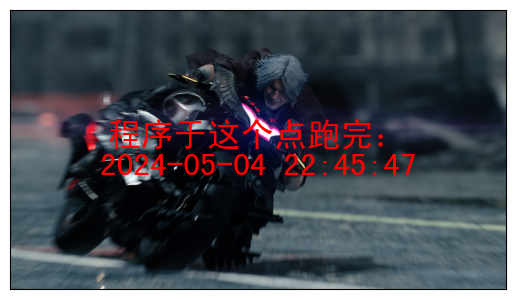

In [127]:
run_finish()

In [128]:
model_path = create_trained_models_path("pretrained-bert")
model_path

'/Users/minkexiu/Downloads/GitHub/ML_Tryout/LLM/大规模语言模型：从理论到实践/trained_models/pretrained-bert'

In [129]:
# make the directory if not already there
if not os.path.isdir(model_path):
    os.mkdir(model_path)

In [130]:
# save the tokenizer
tokenizer.save_model(model_path)

['/Users/minkexiu/Downloads/GitHub/ML_Tryout/LLM/大规模语言模型：从理论到实践/trained_models/pretrained-bert/vocab.txt']

In [131]:
# dumping some of the tokenizer config to config file,
# including special tokens, whether to lower case and the maximum sequence length
with open(os.path.join(model_path, "config.json"), "w") as f:
    tokenizer_cfg = {
        "do_lower_case": True,
        "unk_token": "[UNK]",
        "sep_token": "[SEP]",
        "pad_token": "[PAD]",
        "cls_token": "[CLS]",
        "mask_token": "[MASK]",
        "model_max_length": max_length,
        "max_len": max_length,
    }
    json.dump(tokenizer_cfg, f)

In [132]:
tokenizer = BertTokenizerFast.from_pretrained(model_path)

In [133]:
def encode_with_truncation(examples):
    """Mapping function to tokenize the sentences passed with truncation"""
    return tokenizer(
        examples["text"], 
        truncation=True, 
        padding="max_length",
        max_length=max_length, 
        return_special_tokens_mask=True
    )
    
def encode_without_truncation(examples):
    """Mapping function to tokenize the sentences passed without truncation"""
    return tokenizer(
        examples["text"], 
        return_special_tokens_mask=True
    )

In [ ]:
# the encode function will depend on the truncate_longer_samples variable
encode = encode_with_truncation if truncate_longer_samples else encode_without_truncation

# tokenizing the train dataset
train_dataset = d["train"].map(encode, batched=True)

In [135]:
# tokenizing the testing dataset
test_dataset = d["test"].map(encode, batched=True)

Map:   0%|          | 0/7400423 [00:00<?, ? examples/s]

In [136]:
if truncate_longer_samples:
    # remove other columns and set input_ids and attention_mask as PyTorch tensors
    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
    test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
else:
    # remove other columns, and remain them as Python lists
    test_dataset.set_format(columns=["input_ids", "attention_mask", "special_tokens_mask"])
    train_dataset.set_format(columns=["input_ids", "attention_mask", "special_tokens_mask"])

In [138]:
from itertools import chain
# Main data processing function that will concatenate all texts from our dataset
# and generate chunks of max_seq_length.

In [139]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of
    # this drop, you can customize this part to your needs.
    if total_length >= max_length:
        total_length = (total_length // max_length) * max_length
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + max_length] for i in range(0, total_length, max_length)]
        for k, t in concatenated_examples.items()
    }
    return result

In [140]:
# Note that with `batched=True`, this map processes 1,000 texts together, so group_texts throws
# away a remainder for each of those groups of 1,000 texts. You can adjust that batch_size here but
# a higher value might be slower to preprocess.
#
# To speed up this part, we use multiprocessing. See the documentation of the map method
#for more information:
# https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map
if not truncate_longer_samples:
    train_dataset = train_dataset.map(
        group_texts, batched=True, desc=f"Grouping texts in chunks of {max_length}"
    )
    test_dataset = test_dataset.map(
        group_texts, batched=True,desc=f"Grouping texts in chunks of {max_length}"
    )
    # convert them from lists to torch tensors
    train_dataset.set_format("torch")
    test_dataset.set_format("torch")

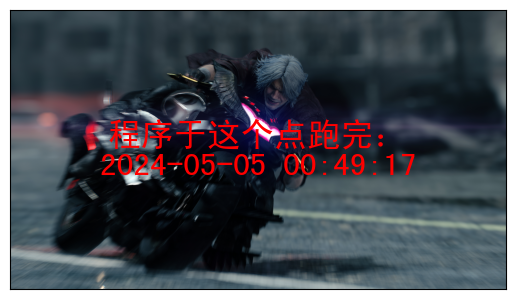

In [141]:
run_finish()

In [142]:
import pickle
with open(
    create_preprocessedData_path("train_dataset.pickle"), 
    'wb'
) as f:  
    # 使用pickle.dump()将对象写入文件  
    pickle.dump(train_dataset, f)  
    
with open(
    create_preprocessedData_path("test_dataset.pickle"), 
    'wb'
) as f:  
    # 使用pickle.dump()将对象写入文件  
    pickle.dump(test_dataset, f)  

In [143]:
# import pickle
# # 现在，我们可以从文件中重新加载对象  
# with open(create_preprocessedData_path("train_dataset.pickle"), 'rb') as f:  
#     # 使用pickle.load()从文件中读取对象  
#     train_dataset = pickle.load(f)   
# with open(create_preprocessedData_path("test_dataset.pickle"), 'rb') as f:  
#     # 使用pickle.load()从文件中读取对象  
#     test_dataset = pickle.load(f)  

In [151]:
from transformers import BertConfig, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, pipeline
from transformers.training_args import TrainingArguments

In [145]:
# initialize the model with the config
model_config = BertConfig(vocab_size=vocab_size, max_position_embeddings=max_length)
model = BertForMaskedLM(config=model_config)

# initialize the data collator, randomly masking 20% (default is 15%) of the tokens
# for the Masked Language Modeling (MLM) task
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.2
)

In [146]:
model = model.to("mps")
model.device

device(type='mps', index=0)

In [147]:
training_args = TrainingArguments(
    output_dir=model_path, # output directory to where save model checkpoint
    evaluation_strategy="steps", # evaluate each `logging_steps` steps
    overwrite_output_dir=True,
    num_train_epochs=1, # number of training epochs, feel free to tweak
    per_device_train_batch_size=10, # the training batch size, put it as high as your GPU memory fits
    gradient_accumulation_steps=8, # accumulating the gradients before updating the weights
    per_device_eval_batch_size=10, # evaluation batch size
    logging_steps=1000, # evaluate, log and save model checkpoints every 1000 step
    save_steps=100,
    # load_best_model_at_end=True, # whether to load the best model (in terms of loss) at the end of training
    # save_total_limit=3, # whether you don't have much space so you let only 3 model weights saved in the disk
)

In [148]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset.select(
        range(10000)
    ),
    eval_dataset=test_dataset.select(
        range(10000)
    ),
)
# train the model
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=125, training_loss=7.6154013671875, metrics={'train_runtime': 1485.7027, 'train_samples_per_second': 6.731, 'train_steps_per_second': 0.084, 'total_flos': 2632048128000000.0, 'train_loss': 7.6154013671875, 'epoch': 1.0})

In [152]:
# load the model checkpoint
model = BertForMaskedLM.from_pretrained(os.path.join(model_path, "checkpoint-100"))

# load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_path)
fill_mask = pipeline(
    "fill-mask", 
    model=model, 
    tokenizer=tokenizer
)

# perform predictions
examples = [
    "Today's most trending hashtags on [MASK] is Donald Trump",
    "The [MASK] was cloudy yesterday, but today it's rainy.",
]
for example in examples:
    for prediction in fill_mask(example):
        print(f"{prediction['sequence']}, confidence: {prediction['score']}")
    print("="*50)

## 因为训练样本非常有限，得到的结果感觉就像瞎掰，达不到很好的效果。
## 没办法，总不能指望我这个电脑去跑大规模训练吧，仔细把电脑搞坏。。。

today's most trending hashtags on. is donald trump, confidence: 0.1454714685678482
today's most trending hashtags on'is donald trump, confidence: 0.040604766458272934
today's most trending hashtags on, is donald trump, confidence: 0.026157645508646965
today's most trending hashtags on the is donald trump, confidence: 0.023251017555594444
today's most trending hashtags on to is donald trump, confidence: 0.009736040607094765
the ` was cloudy yesterday, but today it's rainy., confidence: 0.05748013034462929
the, was cloudy yesterday, but today it's rainy., confidence: 0.029556987807154655
the i was cloudy yesterday, but today it's rainy., confidence: 0.024845274165272713
the the was cloudy yesterday, but today it's rainy., confidence: 0.016106247901916504
the. was cloudy yesterday, but today it's rainy., confidence: 0.012391624040901661
